<a href="https://colab.research.google.com/github/mayapatward/-k-anonymized-ratings/blob/hkulkar-patch-1/collaborativefiltering/collaborativefiltering_usersplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyspark
!pip install -U -q PyDrive
!apt-get update
# Download Java JDK Version 8
!apt install openjdk-8-jdk-headless -qq
!pip install scikit-surprise

In [2]:
%%capture
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Reader, Dataset, NMF, SVD, SVDpp
from surprise.model_selection import cross_validate
from ast import literal_eval
from sklearn.model_selection import train_test_split
import operator
from operator import add


In [3]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics, MultilabelMetrics

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [6]:
RANK_ = 10
klist = [ 5, 8, 12, 15, 20, 25]

In [7]:
def process(raw_data):
  parts = raw_data.map(lambda row: row.value.split(","))
  ratings_RDD_remove = parts.take(1)[0]
  parts = parts.filter(lambda p: p !=ratings_RDD_remove)
  ratingsRDD = parts.map(lambda p: Row(userId = int(p[0]), movieId = int(p[1]), rating = float(p[2])))
  df = spark.createDataFrame(ratingsRDD)
  return df

In [8]:
def map_k(user_to_cluster, x):
    try:
      return (user_to_cluster[x[0]], x[1], x[2], 0)
    except:
      print("EXCEPTION")
      print(x[0], x[1], x[2], 1)

In [9]:
def evaluate(model, test_df):
  testdata = test_df.rdd.map(lambda p: (p[0], p[1]))
  predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
  ratesAndPreds = test_df.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
  MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

  metrics_reg = RegressionMetrics(ratesAndPreds.map(lambda x: x[1]))
  rmse = metrics_reg.rootMeanSquaredError
  
  binaryRankings = test_df.rdd.map(lambda p: (p[0], p[1], 1) if p[2] > 0 else (p[0], p[1], 0))
  userRankings = binaryRankings.filter(lambda x: x[2]==1).map(lambda x: (x[0], x[1]))
  userRankings = userRankings.groupByKey().mapValues(list)


  recommendedRankings = model.recommendProductsForUsers(10)
  recommendedRankings = recommendedRankings.mapValues(lambda x: [r[1] for r in x])
  predictionAndLabels = recommendedRankings.join(userRankings).map(lambda x: ([float(y) for y in x[1][0]], [float(y) for y in x[1][1]]))
  
  
  recommendedRankings_h = model.recommendProductsForUsers(10)
  recommendedRankings_h = recommendedRankings_h.mapValues(lambda x: [r[1] for r in x])
  predictionAndLabels_h = recommendedRankings_h.join(userRankings).map(lambda x: ([float(y) for y in x[1][0]], [float(y) for y in x[1][1]]))
  hitrate_list = predictionAndLabels_h.map(lambda x: 1 if len(set(x[0]).intersection(x[1]))!=0 else 0).collect()
  
  metrics_multi = MultilabelMetrics(predictionAndLabels)

  recall = metrics_multi.recall()
  precision = metrics_multi.precision()
  hitrate = np.array(hitrate_list).mean()

  print("Root Mean Squared Error = " + str(metrics_reg.rootMeanSquaredError))
  print("Recall = " + str(metrics_multi.recall()))
  print("Precision = " + str(metrics_multi.precision()))
  print("Hitrate = "+str(hitrate))

  print("")
  return rmse, recall, precision, hitrate


In [45]:
def save_model_anonymized(metric_):
  for i in range (2,6):
    for k in klist:
      READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/train_test_v2/rawdata_split/iter_{}_fix/'.format(i)
      trainpath = READ_PATH+"postprocessed_anonymized/"+ str(k)+"_anonymized_processed.csv"
      ktrain_rdd = spark.read.text(trainpath).rdd
      ktrain_df = process(ktrain_rdd)
      ktrain_model = ALS.train(ktrain_df, rank = RANK_, nonnegative = True)
      try:
        ktrain_model.save(sc, READ_PATH+"user_{}_{}.model".format(k, metric_))
      except:
        print("Model alrady exists")



In [57]:
def predict(READ_PATH, metric_):
  rmselist = []
  recalllist = []
  precisionlist = []
  hitratelist = []
  for k in klist:
    print("Running k =", k)
    mappingpath_idtoidx = READ_PATH+"user_to_idx.json"
    mappingpath_idxtokanon = READ_PATH+ str(k)+"_anonymized_idx_to_kanon_idx.json"
    

    test_raw = spark.read.text(READ_PATH + "ratings_test.csv").rdd
    test_df = process(test_raw)

    u = Utility(split_type = 'users')
    user_to_cluster = u.get_closest_k_cluster_to_user_id(k, metric=metric_)
    user_to_cluster = {int(i): int(j) for i, j in user_to_cluster.items()}  

    
    with open(mappingpath_idxtokanon, 'r') as f:
        idx_to_kanon = literal_eval(f.read())
    idx_to_kanon = {int(i): int(j) for i, j in idx_to_kanon.items()}

    with open(mappingpath_idtoidx, 'r') as f:
        id_to_idx = literal_eval(f.read())
    id_to_idx = {int(i): int(j) for i, j in id_to_idx.items()}
    ktrain_model = MatrixFactorizationModel.load(sc, READ_PATH+"user_{}_{}.model".format(k, metric_))
    mapped = test_df.rdd.map(lambda x: map_k(user_to_cluster, x))
    mapped_row = mapped.map(lambda x: Row(userId = int(x[0]), movieId = int(x[1]), rating = float(x[2])))
    thrownout = mapped.map(lambda x: x[3]).reduce(add)
    actual = spark.createDataFrame(mapped_row)  
    print("Number points not mapped to cluster: "+str(thrownout))
    rmse, recall, precision, hitrate = evaluate(ktrain_model, actual)
    rmselist += [rmse]
    recalllist += [recall]
    precisionlist += [precision]
    hitratelist += [hitrate]
  return rmselist, recalllist, precisionlist, hitratelist
  


In [39]:
def driver(metric_):
  rmsetotals = np.zeros(len(klist))
  precisiontotals = np.zeros(len(klist))
  recalltotals = np.zeros(len(klist))
  hitratetotals = np.zeros(len(klist))
 
  for i in range (2,6):
    READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/train_test_v2/rawdata_split/iter_{}_fix/'.format(i)

    training_raw = spark.read.text(READ_PATH + "ratings_train.csv").rdd
    test_raw = spark.read.text(READ_PATH + "ratings_test.csv").rdd

    training_df = process(training_raw)
    test_df = process(test_raw)

    r, re, p, h = predict(READ_PATH, metric_)
    rmsetotals = np.vstack((rmsetotals, r))
    recalltotals = np.vstack((recalltotals, re))
    precisiontotals = np.vstack((precisiontotals, p))
    hitratetotals = np.vstack((hitratetotals, h))
  return rmsetotals[1:], recalltotals[1:],precisiontotals[1:], hitratetotals[1:]


In [46]:
def save_model_unanonymized(metric_):
   for i in range (2,6):
      READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/train_test_v2/rawdata_split/iter_{}_fix/'.format(i)
      training_raw = spark.read.text(READ_PATH + "ratings_train.csv").rdd
      training_df = process(training_raw)
      model = ALS.train(training_df.rdd, rank = 10, nonnegative=True)
      try:
        model.save(sc, READ_PATH+"user_unanonymized_{}.model".format(metric_))
      except:
        print("model already exists")


In [52]:
def driver_unanonymized(metric_):
  rmsetotals_0 = 0
  precisiontotals_0 = 0
  recalltotals_0 = 0
  hitratetotals_0 = 0

  for i in range (2,6):
    READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/train_test_v2/rawdata_split/iter_{}_fix/'.format(i)
    test_raw = spark.read.text(READ_PATH + "ratings_test.csv").rdd
    test_df = process(test_raw)

    model = MatrixFactorizationModel.load(sc, READ_PATH+"user_unanonymized_{}.model".format(metric_))

    user_to_cluster = Utility('users').get_closest_k_cluster_to_user_id(0, metric_)
    user_to_cluster = {int(i): int(j) for i, j in user_to_cluster.items()}  

    mapped = test_df.rdd.map(lambda x: map_k(user_to_cluster, x))
    
    mapped_row = mapped.map(lambda x: Row(userId = int(x[0]), movieId = int(x[1]), rating = float(x[2])))
    thrownout = mapped.map(lambda x: x[3]).reduce(add)
    actual = spark.createDataFrame(mapped_row)  
    print("Number points not mapped to cluster: "+str(thrownout))


    r, re, p, h = evaluate(model, actual)
    rmsetotals_0 = rmsetotals_0+r
    recalltotals_0 = recalltotals_0+re
    precisiontotals_0 =precisiontotals_0+p
    hitratetotals_0 = hitratetotals_0+h

  return rmsetotals_0/5, recalltotals_0/5, precisiontotals_0/5, hitratetotals_0/5

In [48]:
##do not run if models are already saved
save_model_unanonymized("jaccard")

In [49]:
save_model_unanonymized("euclidean")

In [50]:
save_model_anonymized("jaccard")

Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25


In [51]:
save_model_anonymized("euclidean")

Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25



Running k = 5



Running k = 8



Running k = 12



Running k = 15



Running k = 20



Running k = 25


In [55]:
rmsetotals,recalltotals, precisiontotals, hitratetotals =  driver(metric_="jaccard")

Running k = 5


NameError: ignored

In [58]:
rmsetotals_e,recalltotals_e, precisiontotals_e, hitratetotals_e = driver(metric_="euclidean")

Running k = 5



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.6752644936487044
Recall = 0.035367674484432
Precision = 0.34523809523809523
Hitrate = 0.8095238095238095

Running k = 8



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.4651481910563033
Recall = 0.031161656791417656
Precision = 0.3461538461538462
Hitrate = 0.8205128205128205

Running k = 12



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.2352146107160356
Recall = 0.03254960819539075
Precision = 0.36333333333333334
Hitrate = 0.9666666666666667

Running k = 15



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.171035417282859
Recall = 0.026881334230619974
Precision = 0.4043478260869566
Hitrate = 0.8260869565217391

Running k = 20



Number points not mapped to cluster: 0
Root Mean Squared Error = 1.9859632496691444
Recall = 0.029942915356930125
Precision = 0.38181818181818183
Hitrate = 0.8636363636363636

Running k = 25



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.0494250432309222
Recall = 0.01067531240768033
Precision = 0.2823529411764706
Hitrate = 0.6470588235294118

Running k = 5



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.8536126259772345
Recall = 0.03420057736004441
Precision = 0.2977272727272728
Hitrate = 0.8409090909090909

Running k = 8



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.5361881040945717
Recall = 0.030428761456980664
Precision = 0.31714285714285717
Hitrate = 0.8571428571428571

Running k = 12



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.3340561749646516
Recall = 0.028843170412021935
Precision = 0.3266666666666667
Hitrate = 0.8

Running k = 15



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.1000850182146693
Recall = 0.01684265787093086
Precision = 0.21724137931034485
Hitrate = 0.7586206896551724

Running k = 20



Number points not mapped to cluster: 0
Root Mean Squared Error = 1.976941414210748
Recall = 0.02118989513410407
Precision = 0.2956521739130435
Hitrate = 0.8260869565217391

Running k = 25



Number points not mapped to cluster: 0
Root Mean Squared Error = 1.7296920901780068
Recall = 0.012960413491748635
Precision = 0.24117647058823527
Hitrate = 0.7647058823529411

Running k = 5



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.6579339026314406
Recall = 0.04802620858531946
Precision = 0.31500000000000006
Hitrate = 0.8

Running k = 8



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.499158528794771
Recall = 0.03299268066353929
Precision = 0.2823529411764706
Hitrate = 0.7941176470588235

Running k = 12



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.1533434282219077
Recall = 0.028567276717155258
Precision = 0.30000000000000004
Hitrate = 0.8620689655172413

Running k = 15



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.227729748358379
Recall = 0.024129808875762104
Precision = 0.3538461538461538
Hitrate = 0.8076923076923077

Running k = 20



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.348027221813121
Recall = 0.018732931735888296
Precision = 0.29545454545454547
Hitrate = 0.7727272727272727

Running k = 25



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.433071716018032
Recall = 0.013296536180933065
Precision = 0.24705882352941172
Hitrate = 0.7058823529411765

Running k = 5



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.6656613724090072
Recall = 0.047497217149786566
Precision = 0.3659574468085106
Hitrate = 0.851063829787234

Running k = 8



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.41679701055232
Recall = 0.022058838648501375
Precision = 0.27948717948717955
Hitrate = 0.717948717948718

Running k = 12



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.1782186913577637
Recall = 0.02933269456159229
Precision = 0.25757575757575757
Hitrate = 0.7272727272727273

Running k = 15



Number points not mapped to cluster: 0
Root Mean Squared Error = 2.228222609408653
Recall = 0.014722245642145153
Precision = 0.26785714285714285
Hitrate = 0.8214285714285714

Running k = 20



Number points not mapped to cluster: 0
Root Mean Squared Error = 1.9736282717400433
Recall = 0.01580475895519466
Precision = 0.24545454545454548
Hitrate = 0.7272727272727273

Running k = 25



Number points not mapped to cluster: 0
Root Mean Squared Error = 1.9970872921190066
Recall = 0.011467825183278183
Precision = 0.3
Hitrate = 0.7058823529411765



In [17]:
rmsetotals_0,recalltotals_0, precisiontotals_0, hitratetotals_0 = driver_unanonymized()


Number points not mapped to cluster: 0
Root Mean Squared Error = 1.3602709584575607
Recall = 0.0022418106721350454
Precision = 0.012499999999999999
Hitrate = 0.125




Number points not mapped to cluster: 0
Root Mean Squared Error = 1.5033636073497008
Recall = 0.00036125307491615706
Precision = 0.005882352941176471
Hitrate = 0.058823529411764705




Number points not mapped to cluster: 0
Root Mean Squared Error = 1.3638561026552065
Recall = 0.0006073646063796117
Precision = 0.012244897959183675
Hitrate = 0.10204081632653061




Number points not mapped to cluster: 0
Root Mean Squared Error = 1.4897853886428791
Recall = 0.0002984178228235953
Precision = 0.006250000000000001
Hitrate = 0.0625



In [30]:
def plot(rmselist, recalllist, precisionlist, hitratelist, klist):
  plt.plot(klist, rmselist, "-o")
  plt.title("RMSE over K-values")
  plt.xticks(ticks=klist)
  plt.xlabel("k")
  plt.ylabel("RMSE")
  plt.show()

  plt.plot(klist, recalllist, "-o")
  plt.title("Recall over K-values")
  plt.xticks(ticks=klist)
  plt.xlabel("k")
  plt.ylabel("recall @ 10")
  plt.show()

  plt.plot(klist, precisionlist, "-o")
  plt.title("Precision over K-values")
  plt.xticks(ticks=klist)
  plt.xlabel("k")
  plt.ylabel("precision @ 10")
  plt.show()

  plt.plot(klist, hitratelist, "-o")
  plt.title("Hitrate over K-values")
  plt.xticks(ticks=klist)
  plt.xlabel("k")
  plt.ylabel("hit rate @ 10")
  plt.show()






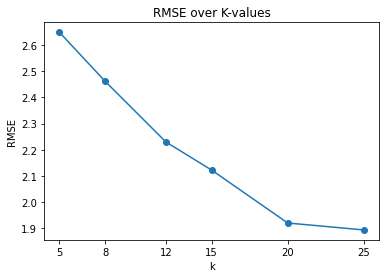

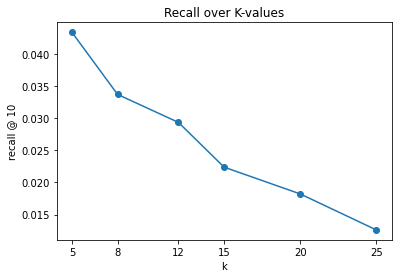

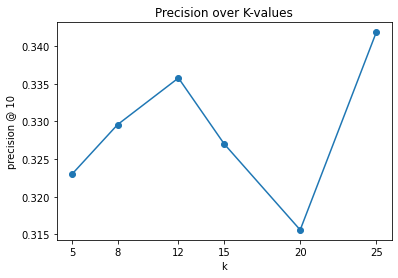

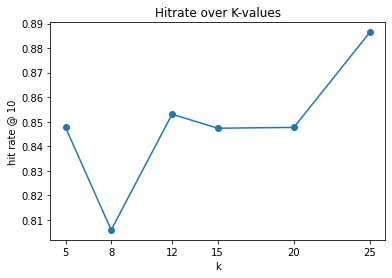

In [59]:
#truncated, jaccard
klist = [5, 8, 12, 15, 20, 25]

rmse_mean_totals = np.mean(rmsetotals, axis = 0)
precision_mean_totals = np.mean(precisiontotals, axis = 0)
recall_mean_totals = np.mean(recalltotals, axis = 0)
hitrate_mean_totals = np.mean(hitratetotals, axis = 0)
plot(rmse_mean_totals,recall_mean_totals,precision_mean_totals, hitrate_mean_totals,klist)


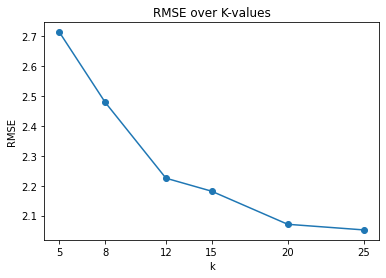

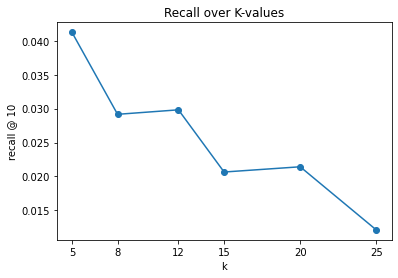

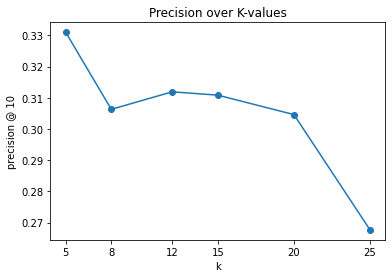

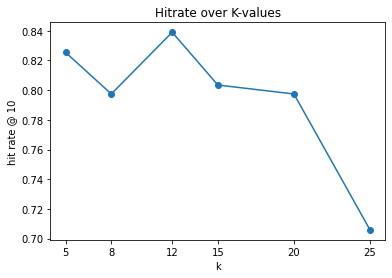

In [60]:
#truncated, euclid
klist = [5, 8, 12, 15, 20, 25]

rmse_mean_totals_e = np.mean(rmsetotals_e, axis = 0)
precision_mean_totals_e = np.mean(precisiontotals_e, axis = 0)
recall_mean_totals_e = np.mean(recalltotals_e, axis = 0)
hitrate_mean_totals_e = np.mean(hitratetotals_e, axis = 0)
plot(rmse_mean_totals_e,recall_mean_totals_e,precision_mean_totals_e, hitrate_mean_totals_e, klist)

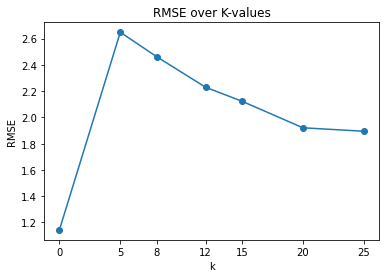

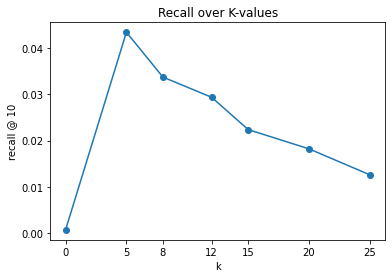

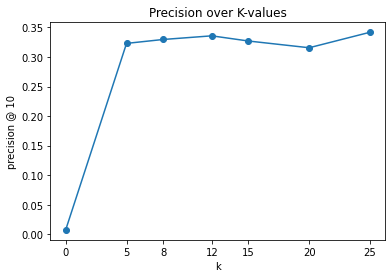

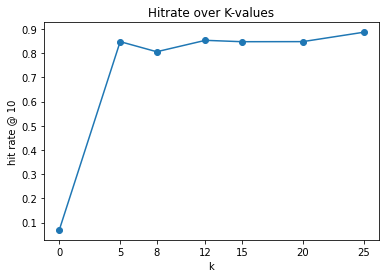

In [61]:
##full, jacard
klist = [0, 5, 8, 12, 15, 20, 25]
rmse_mean_totals = np.insert(np.mean(rmsetotals, axis = 0),0, rmsetotals_0)
precision_mean_totals = np.insert(np.mean(precisiontotals, axis = 0),0, precisiontotals_0)
recall_mean_totals = np.insert(np.mean(recalltotals, axis = 0),0, recalltotals_0)
hitrate_mean_totals = np.insert(np.mean(hitratetotals, axis = 0),0, hitratetotals_0)

plot(rmse_mean_totals,recall_mean_totals,precision_mean_totals,hitrate_mean_totals, klist)

In [14]:
"""Utility.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1WG2j9BIjfuZSZskv7sRB5D_XDu6eclz-
"""
from tqdm.notebook import tqdm
import os
import json
import numpy as np
import pandas as pd
from scipy.spatial import distance

COL_NAME_USER_ID = "userId"
COL_NAME_MOVIE_ID = "movieId"
COL_NAME_ITEM_ID = COL_NAME_MOVIE_ID
COL_NAME_RATING = "rating"
COL_NAME_MOVIE_RATINGS = "movies_and_ratings"

#from google.colab import drive
#drive.mount("/content/drive",force_remount=True)

BASE_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/'
class Utility:
    
    def __init__(self, split_type, base_path=BASE_PATH, iteration=1):
        """Init the utility class
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        splits_and_paths = self.get_splits_and_paths()
        if split_type not in splits_and_paths:
          print(f"split_type must be one of {','.join(list(splits_and_paths.keys()))}")
        valid_iterations = set(range(1,6))
        if iteration not in valid_iterations:
          print(f"iteration must be one of {','.join(list(valid_iterations))}")
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        self.base_path = base_path
        self.anonymized_data_path = os.path.join(self.base_path, splits_and_paths[split_type], f"iter_{iteration}_fix")

        self.ratings_file_name =  'ratings.csv'

        self.training_file_name = 'ratings_train.csv'
        self.test_file_name = 'ratings_train.csv'
        self.validation_file_name = 'ratings_validation.csv'
        self.evaluation_file_name = 'evaluation.csv'
        self.user_movie_ratings_matrix_file_name = 'user_movie_ratings_matrix.csv'
        self.user_to_idx_file_name =  "user_to_idx.json"
        self.movie_to_idx_file_name =  "movie_to_idx.json"

        self.k_anonymized_postfix = '_anonymized.csv'
        self.k_anonymized_map_postfix = '_anonymized_idx_to_kanon_idx.json'
    
    def get_training_user_itemlist(self):
      training_data,_,_ = self.get_unanonymized_training_data()
      return training_data.groupby(COL_NAME_USER_ID)[COL_NAME_MOVIE_ID].agg(set)
  
    def get_test_user_itemlist(self):
      test_data = self.get_test_data()
      return test_data.groupby(COL_NAME_USER_ID)[COL_NAME_MOVIE_ID].agg(set)
  

    def generate_evaluation_dataframe(self, num_negative_items_to_sample_per_user=100):
      training_data = self.get_training_user_itemlist()
      test_data = self.get_test_user_itemlist()
      users = np.unique(np.concatenate([training_data.index.values, test_data.index.values]))
      all_items_to_consider = set(self.get_movie_to_col_index().keys())
      evaluation_df = self.get_test_data()
      rows_to_add = []
      for user in users:
          items_in_train = training_data.loc[user]
          items_in_test = test_data.loc[user]
          neg_items = all_items_to_consider - items_in_train - items_in_test
          neg_items = np.random.choice(list(neg_items), size=num_negative_items_to_sample_per_user, replace=False)
          rows_to_add.extend([{COL_NAME_USER_ID:user, COL_NAME_MOVIE_ID:item, COL_NAME_RATING:0.0} for item in neg_items])
      evaluation_df = evaluation_df.append(rows_to_add, True)
      return evaluation_df
    
    def get_evaluation_path(self):
      return os.path.join(self.anonymized_data_path,self.evaluation_file_name)

    def save_evaluation_df_to(self, df, overwrite=False):
      if os.path.exists(self.get_evaluation_path()) and not(overwrite):
        print("File exists, if you want to overwrite, then pass the arugment to")
        return
      df.to_csv(self.get_evaluation_path())
    
    def get_evaluation_data(self):
      return pd.read_csv(self.get_evaluation_path())

    def get_splits_and_paths(self):
      return {
            'ratings': 'ratings_split',
            'users': 'train_test_v2/rawdata_split'
        }

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2) ** 2
    
    def manhattan_distance(self, point1, point2):
        return abs(point1 - point2).sum()
    
    def jaccard_distance(self, point1, point2):
      return distance.jaccard(point1, point2)
  
    def find_closest_point(self, points_list, point, metric='euclidean'):

        min_distance = float('inf')
        min_distance_idx = -1
        i = 0
        for p in points_list:
            if metric == 'euclidean':
                distance = self.euclidean_distance(p, point)
            elif metric == 'manhattan':
                distance = self.manhattan_distance(p, point)
            elif metric == 'jaccard':
                distance = self.jaccard_distance(p, point)
            else:
                print('Function not implemented!')

            if distance < min_distance:
                min_distance = distance
                min_distance_idx = i
            
            i += 1
        
        return min_distance_idx

    def flatten_matrix_into_dataframe(self, matrix):
      value_vars = [v for v in matrix.columns.values if v != COL_NAME_USER_ID]
      DEFAULT_VARIABLE_NAME_IN_MELT="variable"
      DEFAULT_VALUE_NAME_IN_MELT="value"
      movies_dict = self.get_col_to_movie_index()
      matrix = matrix \
        .melt(id_vars=[COL_NAME_USER_ID], value_vars=value_vars) \
        .rename(columns={DEFAULT_VARIABLE_NAME_IN_MELT: COL_NAME_MOVIE_ID, DEFAULT_VALUE_NAME_IN_MELT: COL_NAME_RATING}) \
        .apply(lambda x : pd.to_numeric(x, downcast='integer'))
      matrix[COL_NAME_MOVIE_ID] = matrix[COL_NAME_MOVIE_ID].apply(lambda x: movies_dict[x])
      matrix[COL_NAME_USER_ID] = matrix[COL_NAME_USER_ID] + 1
      matrix = matrix[matrix[COL_NAME_RATING] > 0]
      return matrix

    def get_training_data_file_path(self, k:int):
      if k ==0:
        return os.path.join(self.anonymized_data_path, "user_movie_ratings_matrix.csv")
      return os.path.join(self.anonymized_data_path, f"{k}{self.k_anonymized_postfix}")

    def get_test_data_file_path(self):
      return os.path.join(self.anonymized_data_path, self.test_file_name)

    def get_training_data(self, k:int):
      mldf = pd.read_csv(self.get_training_data_file_path(k), header=None).reset_index().rename(columns={'index': COL_NAME_USER_ID})
      mldf= self.flatten_matrix_into_dataframe(mldf)
      return mldf, len(mldf[COL_NAME_USER_ID].unique()), len(mldf[COL_NAME_MOVIE_ID].unique())

    def get_training_data_for_evaluation(self):
      mldf = pd.read_csv(self.get_training_data_path())
      return self._group_and_get_sets_for_evaluation(mldf)

    def get_test_data(self):
      return pd.read_csv(self.get_test_data_file_path()).apply(lambda x : pd.to_numeric(x, downcast='integer'))

    def _group_and_get_sets_for_evaluation(self, df):
      testdf=df.sort_values(by=COL_NAME_RATING, ascending=False)
      grouped=testdf.groupby(COL_NAME_USER_ID).agg({COL_NAME_MOVIE_ID:lambda x: list(x), COL_NAME_RATING:lambda x: list(x)})
      grouped[COL_NAME_MOVIE_RATINGS] = grouped.apply(lambda x: list(zip(x[COL_NAME_MOVIE_ID], x[COL_NAME_RATING])), axis=1)
      grouped=grouped.drop(columns=[COL_NAME_RATING])
      return grouped

    def get_unanonymized_training_data(self):
      df = pd.read_csv(self.get_training_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())

    def get_complete_data_path(self):
      return os.path.join(self.base_path, self.ratings_file_name)

    def get_complete_data(self):
      df = pd.read_csv(self.get_complete_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())
  
    def get_evaluation_data_for_evaluation(self):
      df = self.get_evaluation_data()
      return self._group_and_get_sets_for_evaluation(df)
    
    def get_test_data_for_evaluation(self):
      testdf=self.get_test_data()
      return self._group_and_get_sets_for_evaluation(testdf)
  
    def get_training_data_path(self):
        """Get path to training file
        Keyword arguments
        base_path -- The directory where files are located. 
        """        
        return os.path.join(self.anonymized_data_path, self.training_file_name)       

    def get_test_data_path(self):
        """Get path to test file
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.test_file_name)
    
    def get_validation_data_path(self):
        """Get path to validation file
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.validation_file_name)
    
    def get_train_data_user_map_path(self):
        """Get path to user id to train index file map
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.user_to_idx_file_name)
    
    def get_train_data_movie_map_path(self):
        """Get path to movie id to train index file map
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.movie_to_idx_file_name)
   
    def _coalesce_path(self,path1, path2):
      return path1 if path1 != "" else path2

    def get_utility_matrix_from_train(self):      
        # df = pd.read_csv(file_path) # Bug fix -- Check the whole dataset now and map all movies
        df, _, _ = self.get_complete_data()
        
        movie_id_to_idx_dict = self.get_movie_to_col_index()

        users = df.userId.unique()
        test_user_dict = {users[i]: i for i in range(len(users))}

        num_users = len(df.userId.unique())
        num_movies = len(movie_id_to_idx_dict) + 1
        utility_matrix = np.zeros((num_users, num_movies))

        for index, row in df.iterrows():
            movie_id, rating = int(row[COL_NAME_MOVIE_ID]), float(row[COL_NAME_RATING])
            utility_matrix[test_user_dict[row[COL_NAME_USER_ID]]][0] = int(row[COL_NAME_USER_ID])
            
            if movie_id in movie_id_to_idx_dict:
                utility_matrix[test_user_dict[row[COL_NAME_USER_ID]]][movie_id_to_idx_dict[movie_id]] = rating
            #else:
            #   print(f'Movie ID {movie_id} not found!')
        
        return utility_matrix
    
    def get_k_anonymized_map_path(self, k, base_path=""):
        """Get path to k-anonymzied map. 
        {k}_anonymized_idx_to_kanon_idx.json --> the mapping from user index 
        (row in the ratings_train.csv) to the row index in the 
        corresponding {k}_anonymized.csv file
        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path,f"{k}{self.k_anonymized_map_postfix}")
    
    def get_col_to_movie_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path()
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {v:int(k) for k,v in movie_id_to_idx_dict.items()}

    def get_movie_to_col_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path()
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {int(k):v for k,v in movie_id_to_idx_dict.items()}

    def get_feature_vector_for_user(self, movie_ratings:list):
        """Returns a vector, with the same dimentions as the 
        training dataset. 
        Keyword arguments
        movie_ratings -- A list of tuples. Each tuple should be
        as follows: (movie_id, rating)
        """
        movie_to_idx_path = self.get_train_data_movie_map_path()
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        
        feature_vec = [0 for _ in range(len(movie_id_to_idx_dict))]
        movie_not_found= 0
        for movie_id, rating in movie_ratings:
            movie_id, rating = int(movie_id), int(rating)

            if movie_id in movie_id_to_idx_dict.keys():
                feature_vec[movie_id_to_idx_dict[movie_id]] = rating
            else:
                movie_not_found += 1
                #print(f'Movie ID {movie_id} not found!')
        print(f"{movie_not_found} movies not found.")
        return feature_vec
       
    def get_col_to_user_index(self):
      id_to_idx_path = self.get_train_data_user_map_path()
      with open(id_to_idx_path) as json_file:
          id_to_idx_dict = json.load(json_file)
      return {int(k):v for k,v in id_to_idx_dict.items()}
    
    def get_col_to_kanoncol_index(self, k):
      idx_to_kidx_path = self.get_k_anonymized_map_path(k, self.base_path)
      with open(idx_to_kidx_path) as json_file:
        idx_to_kidx_path_dict = json.load(json_file)
      return {int(k):v for k,v in idx_to_kidx_path_dict.items()}

    def get_ks(self):
      return [0, 5,8,12,15,20,25]

    def get_closest_k_cluster_to_user_id(self, k:int, metric="jacard"):
        id_to_idx_dict = self.get_col_to_user_index()
        idx_to_kidx_path_dict = self.get_col_to_kanoncol_index(k) if k!=0 else None
        k_anon_data_path = self.get_training_data_file_path(k)
       

        k_anaon_data = pd.read_csv(k_anon_data_path, sep=',', header=None).apply(pd.to_numeric).values

        u_matrix = self.get_utility_matrix_from_train()

        user_to_cluster_dict = {}
        for um in tqdm(u_matrix):
            user_id = int(um[0])
            row_vec = um[1:]
        
            # Easy case - We have trained on this user before
            # Just need to lookup, to see what cluster they belong to
            if user_id in id_to_idx_dict and\
            k!=0 and id_to_idx_dict[user_id] in idx_to_kidx_path_dict:            
              user_to_cluster_dict[user_id] = idx_to_kidx_path_dict[id_to_idx_dict[user_id]]
            elif user_id in id_to_idx_dict and k==0: # user maps to themselves, they were in training data
              user_to_cluster_dict[user_id] = id_to_idx_dict[user_id]
            else:
              #print(f'{user_id} not found in training data!')
              user_to_cluster_dict[user_id] = self.find_closest_point(k_anaon_data, row_vec, metric)
              #print(f'{user_id} mapped to {user_to_cluster_dict[user_id]}')
        
        return user_to_cluster_dict
      
    
def avg_mahalanobis_dist(user_movie_matrix, anon_matrix, useridx_to_cluster):
    ##user_movie_matrix and anon_matrix are numpy arrays
    #useridx_to_cluster is a dictionary mapping the index to a cluster
    d = dict()
    stdev = np.std(anon_matrix, axis = 0)
    for u, user in enumerate(user_movie_matrix):
        ##some users are not mapped to clusters
        if u in useridx_to_cluster.keys():
            cluster_idx = idx_to_cluster[u]
            cluster = anon_matrix[cluster_idx]
            d[u] = mahalanobis_dist(user, cluster, stdev)
    return np.mean(list(d.values()))

In [ ]:
Utility('users').get_closest_k_cluster_to_user_id(0)